# 图像生成 &mdash; StyleGAN2

生成方法尤其是生成对抗网络GAN产生的图像的分辨率和质量在过去有了长足的发展。然而，生成器依然是一种黑箱操作，对图像合成过程的各个方面缺乏了解，例如随机特征的起源，对于潜在空间的属性也知之甚少。<br/>
StyleGAN 重新设计了传统 GAN 生成器架构， 以一种新颖的方式控制图像合成过程。其生成器从学习的常量输入中调整 “风格”， 每个卷积层的图像基于潜码（Latent Code）z，因而直接控制不同尺度的图像特征的质量， 结合噪声直接注入网络，这种架构变化使得从生成的图像中的随机变化（例如 雀斑、头发）自动分离无监督高级属性
（例如 姿势、身份），并实现特定尺度的混合和插值操作。<br/>
<img src='./images/gan_stylegan.png' align=center width=70% height=70%/><br/>
StyleGAN 作者 Tero Karras 发现生成器结构里的 AdaIN 对每个 feature map 进行归一化，有可能破坏了 feature 之间的信息，导致少量生成的图片存在水滴状的伪影。经实验证明，去除 AdaIN 操作之后，伪影消失了。因此，作者提出了 StyleGAN2， 基于 StyleGAN， 重新设计了生成器的网络结构。本任务将借助 MindSpore 框架来实现 StyleGAN2 的训练与推理。

## 模型简介

StyleGAN2 在 StyleGAN 的基础上， 对生成器做出了三项主要的改变：

* 简化常量输入生成器之后的处理方式
* 对特征进行归一化时不使用均值
* 将噪声模块移到风格模块之外 <br><br>

<img src='./images/stylegan2_modification.png' width=90% height=90%/>

## 数据集准备

### 下载数据集

#### FFHQ

数据集由 70,000 张分辨率为 1024×1024 的高质量人脸 PNG 图像组成，并且在年龄、种族和图像背景方面包含相当大的差异。它还对眼镜、太阳镜、帽子等配件有很好的覆盖。图像是从 Flickr 抓取的，因此继承了该网站的所有偏见，并使用 dlib 自动对齐和裁剪。仅收集许可证许可下的图像。使用了各种自动过滤器来修剪套装，最后使用 Amazon Mechanical Turk 去除偶尔出现的雕像、绘画或照片。<br>
下载 [数据集文件夹 images1024x1024](https://drive.google.com/drive/folders/1tZUcXDBeOibC6jcMCtgRRz67pzrAHeHL?usp=sharing) 或 [数据集zip文件](https://drive.google.com/file/d/1WvlAIvuochQn_L_f9p3OdFdTiSLlnnhv/view?usp=sharing)。
连接不稳定的话，可以在 [这里](https://zhuanlan.zhihu.com/p/425672555) 下载。数据集大小约 90GB。<br>
下载完毕后，在 src 同级目录下创建文件夹，命名为 dataset。<br>
若下载的是文件夹， 路径为 stylegan2/dataset/ffhq。若下载的是zip文件，路径为 styelgan2/dataset/ffhq.zip. <br>

#### Lsun Car

LSUN 数据库的 Car Object 数据集，该数据集由 89.3万张分辨率为 512×384 的车辆图像组成。LSUN类似 ImageNet 数据集，在 CVPR 2015 和 2016，在 LSUN 挑战研讨会上举办了在此数据集上的图像分类挑战。<br>
下载 [Lsun Car](http://dl.yf.io/lsun/objects/car.zip) 数据集zip文件，数据集大小约 172GB。<br>
解压之后的文件夹包含 data 和 lock 两个 lmdb 格式的文件，把文件夹放到 dataset 下, 命名为 lsun_car_lmdb。<br>
路径为 stylegan2/dataset/lsun_car_lmdb.<br>

数据集文件目录如下：

```text
./dataset/
    ├── ffhq
    |    ├── 00000
    |    |     ├── 00000.png
    |    |     ├── 00001.png
    |    |     ├── 00002.png
    |    |          ......
    |    └── 01000
    |          ├── 01000.png
    |          ├── 01001.png
    |          ├── 01002.png
    |               ......
    └── lsun_car_lmdb
         ├── data.mdb
         └── lock.mdb
```

首先，添加代码执行路径。<br>

In [ ]:
import sys
sys.path.append('./src')

建议您在 notebook 里直接通过命令行修改当前工作路径，%cd path/to/stylegan2/src。欲在 notebook 里查看当前工作路径，!pwd。 若您还没在 notebook 环境中安装 MindSpore 框架，请 !pip install [MindSpore 安装 whl 包 或 MindSpore Installation 官网首页提供的 pip 安装链接，请用 1.7.0 版本，CUDA 版本 = 10.1]

### 转换数据集

FFHQ 数据集如果是文件夹形式，可自行选择与否转换成 zip 文件，影响不大，可以通过数据接口直接读取。<br>
Lsun Car 数据集必须选择把 lmdb 文件转换成 zip 格式，否则数据接口没法直接读取 lmdb 格式的数据。

FFHQ 文件夹转换成 zip 格式，全部 7 万张图片转换完成需数小时（取决于 CPU 性能），这里为了省时演示，只转换了 2 千张，实际训练时务必使用全量数据。<br><br>
这里，我们通过dataset_crop_zip.py 文件的 convert_dataset 函数进行数据转换。<br>


In [ ]:
import argparse

from dataset_crop_zip import convert_dataset

def parse_args():
    """Parameter configuration"""
    args = argparse.ArgumentParser()
    args.add_argument('--source', help='Directory for input dataset', default='../dataset/ffhq/', metavar='PATH')
    args.add_argument('--dest', help='Output archive name for output dataset, must end with "zip"',
                      default='../dataset/ffhq_2k.zip', metavar='PATH')
    args.add_argument('--max_images', help='Output only up to `max-images` images', type=int, default=2000)
    args.add_argument('--resize_filter', help='Filter to use when resizing images',
                      choices=['box', 'lanczos'], default='lanczos')
    args.add_argument('--transform', help='Input crop/resize mode, optional',
                      choices=['center-crop', 'center-crop-wide'])
    args.add_argument('--width', help='Output width, optional', type=int)
    args.add_argument('--height', help='Output height, optional', type=int)
    args = args.parse_known_args()[0]
    return args

convert_dataset(parse_args())

100%|██████████| 2000/2000 [04:17<00:00,  7.76it/s]


Lsun Car 从 lmdb 格式转 zip 格式，这里选择转换 1 万张，强烈建议实际训练的时候全数转换。

In [ ]:
import argparse

from dataset_crop_zip import convert_dataset

def parse_args():
    """Parameter configuration"""
    args = argparse.ArgumentParser()
    args.add_argument('--source', help='Directory for input dataset', default='../dataset/lsun_car_lmdb/', metavar='PATH')
    args.add_argument('--dest', help='Output archive name for output dataset, must end with "zip"',
                      default='../dataset/lsun_car_10k.zip', metavar='PATH')
    args.add_argument('--max_images', help='Output only up to `max-images` images', type=int, default=10000)
    args.add_argument('--resize_filter', help='Filter to use when resizing images',
                      choices=['box', 'lanczos'], default='lanczos')
    args.add_argument('--transform', help='Input crop/resize mode, optional',
                      choices=['center-crop', 'center-crop-wide'], default='center-crop-wide')
    args.add_argument('--width', help='Output width, optional', type=int, default=512)
    args.add_argument('--height', help='Output height, optional', type=int, default=384)
    args = args.parse_known_args()[0]
    return args

convert_dataset(parse_args())

100%|██████████| 10000/10000 [01:16<00:00, 130.91it/s]


### 可视化数据集

执行以下代码，通过 matplotlib 可视化数据集中的随机 30 张图片。

img shape:  (1024, 1024)
Plotting images...


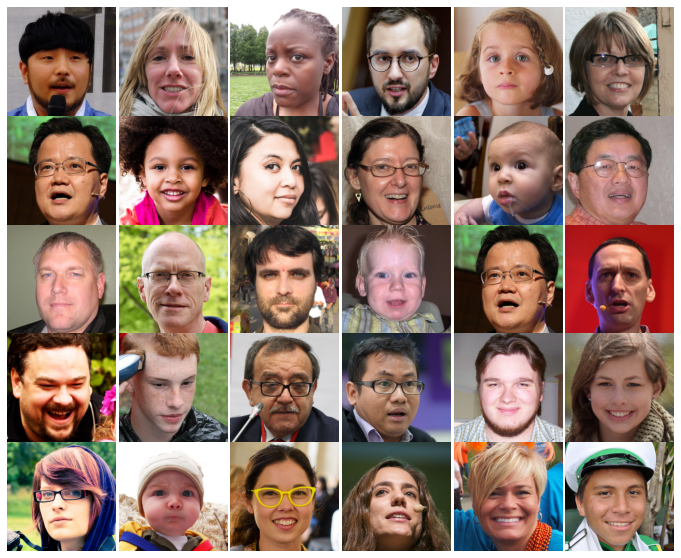

Plotting finished.


In [ ]:
import os
import random

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

random.seed(5)
path = '../dataset/ffhq/00000/'
dataset = sorted(os.listdir(path))
img = PIL.Image.open(path + dataset[0])
print('img shape: ', img.size)

print('Plotting images...')
plt.figure(figsize=(12, 10))
for i in range(1, 31):
    plt.subplot(5, 6, i)
    num = random.randint(0, len(dataset))
    image = PIL.Image.open(path + dataset[num])
    plt.imshow(np.array(image))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
plt.show()
print('Plotting finished.')

同样的，通过运行以下代码，我们可以可视化 Lsun Car zip 格式数据集中的随机 20 张图片。

img shape:  (512, 512)
Plotting images...


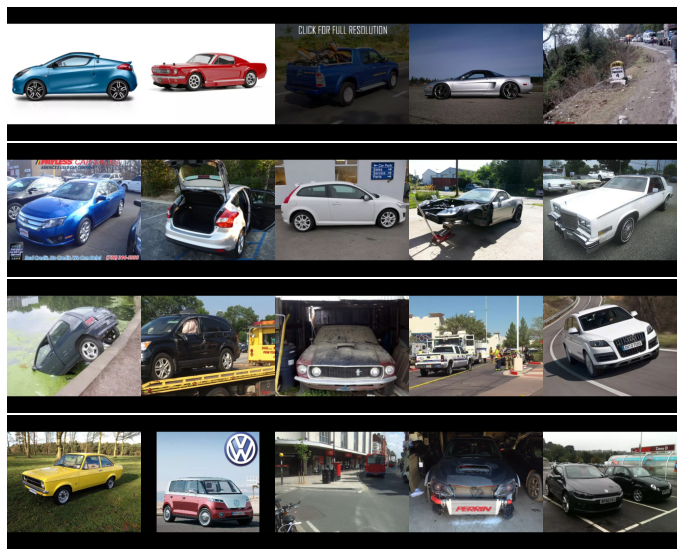

Plotting finished.


In [ ]:
import zipfile

path = '../dataset/lsun_car_10k.zip'
imgzip = zipfile.ZipFile(path)
dataset = imgzip.infolist()
imgfile = imgzip.open(dataset[0])
img = PIL.Image.open(imgfile)
print('img shape: ', img.size)

print('Plotting images...')
plt.figure(figsize=(12, 10))
for i in range(1, 21):
    plt.subplot(4, 5, i)
    num = random.randint(0, len(dataset))
    image = PIL.Image.open(imgzip.open(dataset[num]))
    plt.imshow(np.array(image))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
plt.show()
print('Plotting finished.')

## 构建网络

### 生成器

生成器（Generator）由 映射网络（Mapping Network） 和 生成网络（Synthesis Network）组成。<br>
首先，将潜码（Latent Code）z 通过映射网络映射到中间潜在空间 W，然后通过仿射变换 A 把风格（Style）输入到每一个风格模块（下图灰色方框）。风格和权重经过 “调制” （Modulation） 与 “解调”（Demodulation） 之后输入到卷积层，在每次卷积之后添加偏置 b 和高斯噪声。<br>
这里，A 表示学习的仿射变换，B 将学习的每通道比例因子应用于噪声输入。映射网络 f 由 8 层组成，合成网络 g 由 18 层组成，每个分辨率 2 层（42-10242）。最后一层的输出使用一个单独的 1×1 卷积转换为 RGB 图像。<br>
生成器共有2620万个可训练参数。<br>

<img src='./images/stylegan2_generator.png' align=center width=80% height=80%/>

In [ ]:
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Parameter
import mindspore.numpy as mnp

from model.block import normalize_2nd_moment, FullyConnectedLayer, SynthesisBlock, resample_filter, upsample2d
from model.discriminator import DiscriminatorBlock, DiscriminatorEpilogue

In [ ]:
class Generator(nn.Cell):
    """
    Generator.

    Args:
        z_dim (int): Input latent (Z) dimensionality.
        c_dim (int): Conditioning label (C) dimensionality.
        w_dim (int): Intermediate latent (W) dimensionality.
        img_resolution (int): Output image resolution.
        img_channels (int): Number of output color channels.
        batch_size (int): Batch size. Default: 1.
        train (bool): True: train, False: infer. Default: False.
        mapping_kwargs (dict): Arguments for MappingNetwork. Default: None.
        synthesis_kwargs (dict): Arguments for SynthesisNetwork. Default: None.

    Input:
        - **z** (Tensor) - Latent tensor.
        - **c** (Tensor) - Label tensor.
        - **truncation_psi** (int) - GAN truncation trick. Default: 0.5
        - **truncation_cutoff** (int) - Cutoff for truncation. Default: None
        - **synthesis_kwargs** (dict) - Arguments for SynthesisNetwork.

    Output:
        Tensor, output image.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> generator = Generator(z_dim, c_dim, w_dim, img_resolution, img_channels, mapping_kwargs, synthesis_kwargs)
        >>> x = generator(z, c)
    """

    def __init__(self, z_dim, c_dim, w_dim, img_resolution, img_channels, batch_size=1, train=False,
                 mapping_kwargs=None, synthesis_kwargs=None):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.synthesis = SynthesisNetwork(w_dim=w_dim, img_resolution=img_resolution, img_channels=img_channels,
                                          batch_size=batch_size, train=train, **synthesis_kwargs)
        self.num_ws = self.synthesis.num_ws
        self.mapping = MappingNetwork(z_dim=z_dim, c_dim=c_dim, w_dim=w_dim, num_ws=self.num_ws, **mapping_kwargs)

    def construct(self, z, c, truncation_psi=0.5, truncation_cutoff=None, **synthesis_kwargs):
        """Generator construct"""
        ws = self.mapping(z, c, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        img = self.synthesis(ws, **synthesis_kwargs)
        return img

### 映射网络（Mapping Network）

如前所述，与传统GAN不同，StyleGAN2 的 映射网络将潜码 z 通过 8 个全连接层映射到中间潜在空间 w.

In [ ]:
class MappingNetwork(nn.Cell):
    """
    Mapping Network.

    Args:
        z_dim (int): Input latent (Z) dimensionality, 0 = no latent.
        c_dim (int): Conditioning label (C) dimensionality, 0 = no label.
        w_dim (int): Intermediate latent (W) dimensionality.
        num_ws (int): Number of intermediate latents to output, None = do not broadcast.
        num_layers (int): Number of mapping layers. Default: 8.
        embed_features (bool): Label embedding dimensionality Default: None.
        layer_features (bool): Number of intermediate features in the mapping layers.
            None = same as w_dim. Default: None.
        activation (str): Activation function: 'relu', 'lrelu', etc. Default: 'lrelu'.
        lr_multiplier (float): Learning rate multiplier for the mapping layers. Default: 0.01.
        w_avg_beta (float): Decay for tracking the moving average of W during training,
            None = do not track. Default: 0.995.

    Input:
        - **z** (Tensor) - Latent tensor.
        - **c** (Tensor) - Label tensor.
        - **truncation_psi** (int) - GAN truncation trick. Default: 0.5
        - **truncation_cutoff** (int) - Cutoff for truncation. Default: None
        - **skip_w_avg_update** (bool) - Skip update for moving average of weight. Default: False

    Output:
        Tensor, mapping network output tensor.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        mapping = MappingNetwork(z_dim, c_dim, w_dim, num_ws)
        ws = mapping(z, c)
    """

    def __init__(self, z_dim, c_dim, w_dim, num_ws, num_layers=8, embed_features=None,
                 layer_features=None, activation='lrelu', lr_multiplier=0.01, w_avg_beta=0.995):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.num_ws = num_ws
        self.num_layers = num_layers
        self.w_avg_beta = w_avg_beta
        self.layer = nn.CellList()

        if embed_features is None:
            embed_features = w_dim
        if c_dim == 0:
            embed_features = 0
        if layer_features is None:
            layer_features = w_dim
        features_list = [z_dim + embed_features] + [layer_features] * (num_layers - 1) + [w_dim]

        if c_dim > 0:
            self.embed = FullyConnectedLayer(c_dim, embed_features)
        for idx in range(num_layers):
            in_features = features_list[idx]
            out_features = features_list[idx + 1]
            layer = FullyConnectedLayer(in_features, out_features, activation=activation, lr_multiplier=lr_multiplier)
            self.layer.append(layer)

        if num_ws is not None and w_avg_beta is not None:
            self.w_avg = Parameter(ops.Zeros()(w_dim, ms.float32))

    def construct(self, z, c, truncation_psi=0.5, truncation_cutoff=None, skip_w_avg_update=False):
        """Mapping network construct"""
        # Embed, normalize, and concat inputs.
        x = None
        if self.z_dim > 0:
            x = normalize_2nd_moment(z.astype(ms.float32))
        if self.c_dim > 0:
            y = normalize_2nd_moment(self.embed(c.astype(ms.float32)))
            x = ops.Concat(1)((x, y)) if x is not None else y

        # Main layers.
        for layer in self.layer:
            x = layer(x)

        # Update moving average of W.
        if self.w_avg_beta is not None and self.training and not skip_w_avg_update:
            self.w_avg = (x.mean(0) + (self.w_avg - x.mean(0)) * self.w_avg_beta).copy()

        # Broadcast.
        if self.num_ws is not None:
            x = x.expand_dims(1).repeat(self.num_ws, 1)

        # Apply truncation.
        if truncation_psi != 1:
            if self.num_ws is None or truncation_cutoff is None:
                x = self.w_avg + (x - self.w_avg) * truncation_psi
            else:
                x[:, :truncation_cutoff] = self.w_avg + (x[:, :truncation_cutoff] - self.w_avg) * truncation_psi
        return x

### 生成网络（Synthesis Network）

接下来构建 StyleGAN2 论文种最主要的创新&mdash;&mdash;生成网络。生成网络在不同分辨率下进行上采样，分辨率从 4（2^2）到 1024（2^10），共 9 个模块，每个分辨率对应2层，共18层网络，其中最后一层转换为RGB。

In [ ]:
class SynthesisBlock(nn.Cell):
    """
    Synthesis Block.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        w_dim (int): Intermediate latent (W) dimensionality.
        resolution (int): Resolution of this layer.
        output_res (int): Resolution of final output image to differentiate between ffhq1024 and lsun_car512x384
        img_channels (int): Number of output color channels.
        is_last (bool): Is this the last block?
        architecture (str): Architecture: 'orig', 'skip', 'resnet'. Default: 'skip'.
        conv_clamp (bool): Clamp the output to +-X, None = disable clamping. Default: None.
        use_fp16 (bool): Use FP16 for this block? Default: False.
        batch_size (int): Batch size. Default: 1.
        train (bool): True = train, False = infer. Default: False.
        layer_kwargs (dict): Arguments for SynthesisLayer.

    Inputs:
        - **x** (Tensor) - Input feature.
        - **img** (Tensor) - Input image.
        - **ws** (Tensor) - Intermediate latents.
        - **force_fp32** (bool) - If force the input to float32. Default: False.
        - **fused_modconv** (bool) - Perform modulation, convolution and demodulation
            as a single fused operation? Default: None.
        - **layer_kwargs** (int) - Noise mode, 0 = none, 1 = constant, 2 = random. Default: 2.

    Outputs:
        Tensor, output feature.
        Tensor, output image.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> block = SynthesisBlock(in_channels, out_channels, w_dim, resolution, output_res, img_channels, is_last)
        >>> x, img = block(x, img, ws)
    """

    def __init__(self, in_channels, out_channels, w_dim, resolution, output_res, img_channels, is_last,
                 architecture='skip', conv_clamp=None, use_fp16=False, batch_size=1, train=False, **layer_kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.w_dim = w_dim
        self.resolution = resolution
        self.out_res = output_res
        self.img_channels = img_channels
        self.is_last = is_last
        self.architecture = architecture
        self.use_fp16 = use_fp16
        self.size = batch_size
        self.train = train
        self.num_conv = 0
        self.num_torgb = 0

        if in_channels == 0:
            self.const = Parameter(ops.StandardNormal()((out_channels, resolution, resolution)))

        if in_channels != 0:
            self.conv0 = SynthesisLayer(in_channels, out_channels, w_dim=w_dim, resolution=resolution, up=2,
                                        conv_clamp=conv_clamp, **layer_kwargs)
            self.num_conv += 1

        self.conv1 = SynthesisLayer(out_channels, out_channels, w_dim=w_dim, resolution=resolution,
                                    conv_clamp=conv_clamp, **layer_kwargs)
        self.num_conv += 1

        if is_last or architecture == 'skip':
            self.torgb = ToRGBLayer(out_channels, img_channels, w_dim=w_dim, conv_clamp=conv_clamp)
            self.num_torgb += 1

        if self.out_res == 512:
            self.name_list = ['conv2d'] * 2 + (['transpose2d'] + ['conv2d'] * 4) * 7
            self.dtype_list = ['float32' for _ in range(len(self.name_list))]

        if self.out_res == 1024:
            self.name_list = ['conv2d'] * 2 + (['transpose2d'] + ['conv2d'] * 4) * 8
            self.dtype_list = ['float32' for _ in range(len(self.name_list))]

        if train:
            input_list = [(self.size, 512, 4, 4), (self.size, 512, 4, 4), (self.size, 512, 4, 4),
                          (self.size, 512, 11, 11), (self.size, 512, 8, 8), (self.size, 3, 11, 11),
                          (self.size, 512, 8, 8), (self.size, 512, 8, 8), (self.size, 512, 19, 19),
                          (self.size, 512, 16, 16), (self.size, 3, 19, 19), (self.size, 512, 16, 16),
                          (self.size, 512, 16, 16), (self.size, 512, 35, 35), (self.size, 512, 32, 32),
                          (self.size, 3, 35, 35), (self.size, 512, 32, 32), (self.size, 512, 32, 32),
                          (self.size, 512, 67, 67), (self.size, 512, 64, 64), (self.size, 3, 67, 67),
                          (self.size, 512, 64, 64), (self.size, 512, 64, 64), (self.size, 256, 131, 131),
                          (self.size, 256, 128, 128), (self.size, 3, 131, 131), (self.size, 256, 128, 128),
                          (self.size, 256, 128, 128), (self.size, 128, 259, 259), (self.size, 128, 256, 256),
                          (self.size, 3, 259, 259), (self.size, 128, 256, 256), (self.size, 128, 256, 256),
                          (self.size, 64, 515, 515), (self.size, 64, 512, 512), (self.size, 3, 515, 515),
                          (self.size, 64, 512, 512)]

            weight_list = [(512, 512, 3, 3), (3, 512, 1, 1), (512, 512, 3, 3),
                           (512, 1, 4, 4), (512, 512, 3, 3), (3, 1, 4, 4),
                           (3, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4),
                           (512, 512, 3, 3), (3, 1, 4, 4), (3, 512, 1, 1),
                           (512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 3, 3),
                           (3, 1, 4, 4), (3, 512, 1, 1), (512, 512, 3, 3),
                           (512, 1, 4, 4), (512, 512, 3, 3), (3, 1, 4, 4),
                           (3, 512, 1, 1), (512, 256, 3, 3), (256, 1, 4, 4),
                           (256, 256, 3, 3), (3, 1, 4, 4), (3, 256, 1, 1),
                           (256, 128, 3, 3), (128, 1, 4, 4), (128, 128, 3, 3),
                           (3, 1, 4, 4), (3, 128, 1, 1), (128, 64, 3, 3),
                           (64, 1, 4, 4), (64, 64, 3, 3), (3, 1, 4, 4), (3, 64, 1, 1)]

            if self.out_res == 512:
                self.input_list = input_list
                self.weight_list = weight_list

            if self.out_res == 1024:
                input_list.extend([(self.size, 64, 512, 512), (self.size, 32, 1027, 1027), (self.size, 32, 1024, 1024),
                                   (self.size, 3, 1027, 1027), (self.size, 32, 1024, 1024)])
                self.input_list = input_list
                weight_list.extend([(64, 32, 3, 3), (32, 1, 4, 4),
                                    (32, 32, 3, 3), (3, 1, 4, 4), (3, 32, 1, 1)])
                self.weight_list = weight_list

            conv_list = CellList([self._conv2d(512, 512, 3, 1, 1, 1, 1, 0),
                                  self._conv2d(512, 3, 1, 1, 0, 1, 1, 1),
                                  self._transpose2d(512, 512, 3, 2, 0, 1, 1, 2),
                                  self._conv2d(512, 512, 4, 1, 0, 1, 512 * 1, 3),
                                  self._conv2d(512, 512, 3, 1, 1, 1, 1, 4),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 5),
                                  self._conv2d(512, 3, 1, 1, 0, 1, 1, 6),
                                  self._transpose2d(512, 512, 3, 2, 0, 1, 1, 7),
                                  self._conv2d(512, 512, 4, 1, 0, 1, 512, 8),
                                  self._conv2d(512, 512, 3, 1, 1, 1, 1, 9),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 10),
                                  self._conv2d(512, 3, 1, 1, 0, 1, 1, 11),
                                  self._transpose2d(512, 512, 3, 2, 0, 1, 1, 12),
                                  self._conv2d(512, 512, 4, 1, 0, 1, 512, 13),
                                  self._conv2d(512, 512, 3, 1, 1, 1, 1, 14),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 15),
                                  self._conv2d(512, 3, 1, 1, 0, 1, 1, 16),
                                  self._transpose2d(512, 512, 3, 2, 0, 1, 1, 17),
                                  self._conv2d(512, 512, 4, 1, 0, 1, 512, 18),
                                  self._conv2d(512, 512, 3, 1, 1, 1, 1, 19),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 20),
                                  self._conv2d(512, 3, 1, 1, 0, 1, 1, 21),
                                  self._transpose2d(512, 256, 3, 2, 0, 1, 1, 22),
                                  self._conv2d(256, 256, 4, 1, 0, 1, 256, 23),
                                  self._conv2d(256, 256, 3, 1, 1, 1, 1, 24),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 25),
                                  self._conv2d(256, 3, 1, 1, 0, 1, 1, 26),
                                  self._transpose2d(256, 128, 3, 2, 0, 1, 1, 27),
                                  self._conv2d(128, 128, 4, 1, 0, 1, 128, 28),
                                  self._conv2d(128, 128, 3, 1, 1, 1, 1, 29),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 30),
                                  self._conv2d(128, 3, 1, 1, 0, 1, 1, 31),
                                  self._transpose2d(128, 64, 3, 2, 0, 1, 1, 32),
                                  self._conv2d(64, 64, 4, 1, 0, 1, 64, 33),
                                  self._conv2d(64, 64, 3, 1, 1, 1, 1, 34),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 35),
                                  self._conv2d(64, 3, 1, 1, 0, 1, 1, 36)])

            if self.out_res == 512:
                self.conv_list = conv_list

            if self.out_res == 1024:
                conv_list.extend([self._transpose2d(64, 32, 3, 2, 0, 1, 1, 37),
                                  self._conv2d(32, 32, 4, 1, 0, 1, 32, 38),
                                  self._conv2d(32, 32, 3, 1, 1, 1, 1, 39),
                                  self._conv2d(3, 3, 4, 1, 0, 1, 3, 40),
                                  self._conv2d(32, 3, 1, 1, 0, 1, 1, 41)])
                self.conv_list = conv_list

        else:
            input_list = [(1, 512 * self.size, 4, 4), (1, 512 * self.size, 4, 4), (1, 512 * self.size, 4, 4),
                          (1, 512 * self.size, 11, 11), (1, 512 * self.size, 8, 8), (self.size, 3, 11, 11),
                          (1, 512 * self.size, 8, 8), (1, 512 * self.size, 8, 8), (1, 512 * self.size, 19, 19),
                          (1, 512 * self.size, 16, 16), (self.size, 3, 19, 19), (1, 512 * self.size, 16, 16),
                          (1, 512 * self.size, 16, 16), (1, 512 * self.size, 35, 35), (1, 512 * self.size, 32, 32),
                          (self.size, 3, 35, 35), (1, 512 * self.size, 32, 32), (self.size, 512, 32, 32),
                          (self.size, 512, 67, 67), (self.size, 512, 64, 64), (self.size, 3, 67, 67),
                          (self.size, 512, 64, 64), (self.size, 512, 64, 64), (self.size, 256, 131, 131),
                          (self.size, 256, 128, 128), (self.size, 3, 131, 131), (self.size, 256, 128, 128),
                          (self.size, 256, 128, 128), (self.size, 128, 259, 259), (self.size, 128, 256, 256),
                          (self.size, 3, 259, 259), (self.size, 128, 256, 256), (self.size, 128, 256, 256),
                          (self.size, 64, 515, 515), (self.size, 64, 512, 512), (self.size, 3, 515, 515),
                          (self.size, 64, 512, 512)]

            weight_list = [(512 * self.size, 512, 3, 3), (3 * self.size, 512, 1, 1), (512 * self.size, 512, 3, 3),
                           (512 * self.size, 1, 4, 4), (512 * self.size, 512, 3, 3), (3, 1, 4, 4),
                           (3 * self.size, 512, 1, 1), (512 * self.size, 512, 3, 3), (512 * self.size, 1, 4, 4),
                           (512 * self.size, 512, 3, 3), (3, 1, 4, 4), (3 * self.size, 512, 1, 1),
                           (512 * self.size, 512, 3, 3), (512 * self.size, 1, 4, 4), (512 * self.size, 512, 3, 3),
                           (3, 1, 4, 4), (3 * self.size, 512, 1, 1), (512, 512, 3, 3),
                           (512, 1, 4, 4), (512, 512, 3, 3), (3, 1, 4, 4),
                           (3, 512, 1, 1), (512, 256, 3, 3), (256, 1, 4, 4),
                           (256, 256, 3, 3), (3, 1, 4, 4), (3, 256, 1, 1),
                           (256, 128, 3, 3), (128, 1, 4, 4), (128, 128, 3, 3),
                           (3, 1, 4, 4), (3, 128, 1, 1), (128, 64, 3, 3),
                           (64, 1, 4, 4), (64, 64, 3, 3), (3, 1, 4, 4), (3, 64, 1, 1)]

            if self.out_res == 512:
                self.input_list = input_list
                self.weight_list = weight_list
                conv_list = CellList([self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 0),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 1),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 2),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 3),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 4),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 5),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 6),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 7),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 8),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 9),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 10),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 11),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 12),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 13),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 14),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 15),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 16),
                                      self._transpose2d(512, 512, 3, 2, 0, 1, 1, 17),
                                      self._conv2d(512, 512, 4, 1, 0, 1, 512, 18),
                                      self._conv2d(512, 512, 3, 1, 1, 1, 1, 19),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 20),
                                      self._conv2d(512, 3, 1, 1, 0, 1, 1, 21),
                                      self._transpose2d(512, 256, 3, 2, 0, 1, 1, 22),
                                      self._conv2d(256, 256, 4, 1, 0, 1, 256, 23),
                                      self._conv2d(256, 256, 3, 1, 1, 1, 1, 24),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 25),
                                      self._conv2d(256, 3, 1, 1, 0, 1, 1, 26),
                                      self._transpose2d(256, 128, 3, 2, 0, 1, 1, 27),
                                      self._conv2d(128, 128, 4, 1, 0, 1, 128, 28),
                                      self._conv2d(128, 128, 3, 1, 1, 1, 1, 29),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 30),
                                      self._conv2d(128, 3, 1, 1, 0, 1, 1, 31),
                                      self._transpose2d(128, 64, 3, 2, 0, 1, 1, 32),
                                      self._conv2d(64, 64, 4, 1, 0, 1, 64, 33),
                                      self._conv2d(64, 64, 3, 1, 1, 1, 1, 34),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 35),
                                      self._conv2d(64, 3, 1, 1, 0, 1, 1, 36)])
                self.conv_list = conv_list

            if self.out_res == 1024:
                self.input_list = input_list[0:17] + \
                                  [(1, 512 * self.size, 32, 32), (1, 512 * self.size, 67, 67),
                                   (1, 512 * self.size, 64, 64), (self.size, 3, 67, 67),
                                   (1, 512 * self.size, 64, 64)] + input_list[22:] + \
                                  [(self.size, 64, 512, 512), (self.size, 32, 1027, 1027), (self.size, 32, 1024, 1024),
                                   (self.size, 3, 1027, 1027), (self.size, 32, 1024, 1024)]

                self.weight_list = weight_list[0:17] + [(512 * self.size, 512, 3, 3), (512 * self.size, 1, 4, 4),
                                                        (512 * self.size, 512, 3, 3), (3, 1, 4, 4),
                                                        (3 * self.size, 512, 1, 1)] + weight_list[22:] + \
                                   [(64, 32, 3, 3), (32, 1, 4, 4),
                                    (32, 32, 3, 3), (3, 1, 4, 4), (3, 32, 1, 1)]

                conv_list = CellList([self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 0),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 1),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 2),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 3),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 4),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 5),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 6),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 7),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 8),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 9),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 10),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 11),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 12),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 13),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 14),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 15),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 16),
                                      self._transpose2d(512 * self.size, 512 * self.size, 3, 2, 0, 1, self.size, 17),
                                      self._conv2d(512 * self.size, 512 * self.size, 4, 1, 0, 1, 512 * self.size, 18),
                                      self._conv2d(512 * self.size, 512 * self.size, 3, 1, 1, 1, self.size, 19),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 20),
                                      self._conv2d(512 * self.size, 3 * self.size, 1, 1, 0, 1, self.size, 21),
                                      self._transpose2d(512, 256, 3, 2, 0, 1, 1, 22),
                                      self._conv2d(256, 256, 4, 1, 0, 1, 256, 23),
                                      self._conv2d(256, 256, 3, 1, 1, 1, 1, 24),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 25),
                                      self._conv2d(256, 3, 1, 1, 0, 1, 1, 26),
                                      self._transpose2d(256, 128, 3, 2, 0, 1, 1, 27),
                                      self._conv2d(128, 128, 4, 1, 0, 1, 128, 28),
                                      self._conv2d(128, 128, 3, 1, 1, 1, 1, 29),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 30),
                                      self._conv2d(128, 3, 1, 1, 0, 1, 1, 31),
                                      self._transpose2d(128, 64, 3, 2, 0, 1, 1, 32),
                                      self._conv2d(64, 64, 4, 1, 0, 1, 64, 33),
                                      self._conv2d(64, 64, 3, 1, 1, 1, 1, 34),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 35),
                                      self._conv2d(64, 3, 1, 1, 0, 1, 1, 36),
                                      self._transpose2d(64, 32, 3, 2, 0, 1, 1, 37),
                                      self._conv2d(32, 32, 4, 1, 0, 1, 32, 38),
                                      self._conv2d(32, 32, 3, 1, 1, 1, 1, 39),
                                      self._conv2d(3, 3, 4, 1, 0, 1, 3, 40),
                                      self._conv2d(32, 3, 1, 1, 0, 1, 1, 41)])
                self.conv_list = conv_list

        self.conv_list_weight = ms.ParameterTuple(self.conv_list.get_parameters())
        for param in self.conv_list_weight:
            param.requires_grad = False
        self.conv_info = [self.conv_list, self.conv_list_weight, self.input_list, self.weight_list, self.name_list]

    def _conv2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Conv2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            Cell, function of nn.Conv2d with given weight shape.

        Examples:
            >>> func = _conv2d(512, 512, 3, 1, 1, 1, 1, 0)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func

    def _transpose2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Transpose2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            Cell, function of nn.Conv2dTranspose with given weight shape.

        Examples:
            >>> func = _transpose2d(512, 512, 3, 2, 0, 1, 1, 2)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2dTranspose(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, pad_mode='pad', padding=padding, dilation=dilation,
                                      group=group, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2dTranspose(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, pad_mode='pad', padding=padding, dilation=dilation,
                                      group=group, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func

    def construct(self, x, img, ws, force_fp32=False, fused_modconv=None, noise_mode=0):
        """Synthesis block construct"""
        w_iter = iter(ops.Unstack(axis=1)(ws))
        d_type = ms.float16 if self.use_fp16 and not force_fp32 else ms.float32
        if fused_modconv is None:
            fused_modconv = (not self.training) and (d_type == ms.float32 or x.shape[0] == 1)

        # Input.
        d_type = ms.float32
        if self.in_channels == 0:
            x = self.const.astype(d_type)
            x = mnp.tile(ops.ExpandDims()(x, 0), (ws.shape[0], 1, 1, 1))
        else:
            x = x.astype(d_type)

        # Main layers.
        if self.in_channels == 0:
            x = self.conv1(x, next(w_iter)[0].astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           conv_info=self.conv_info)
        else:
            x = self.conv0(x, next(w_iter)[0].astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           conv_info=self.conv_info)
            x = self.conv1(x, next(w_iter)[0].astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           conv_info=self.conv_info)

        # ToRGB.
        if img is not None:
            img = upsample2d(img, resample_filter, conv_info=self.conv_info)
        if self.is_last or self.architecture == 'skip':
            y = self.torgb(x, next(w_iter)[0], fused_modconv=fused_modconv, conv_info=self.conv_info)
            y = y.astype(ms.float32)
            img = ops.Add()(img, y) if img is not None else y
        return x, img


class SynthesisNetwork(nn.Cell):
    """
    Synthesis Network.

    Args:
        w_dim (int): Intermediate latent (W) dimensionality.
        img_resolution (int): Output image resolution.
        img_channels (int): Number of color channels.
        channel_base (int): Overall multiplier for the number of channels. Default: 32768.
        channel_max (int): Maximum number of channels in any layer. Default: 512.
        num_fp16_res (int): Use FP16 for the N highest resolutions. Default: 0.
        batch_size (int): Batch size. Default: 1.
        train (bool): True = train, False = infer. Default: False.
        block_kwargs (dict): Arguments for SynthesisBlock.

    Input:
        - **ws** (Tensor) - Intermediate latents.
        - **block_kwargs** (dict) - Arguments for SynthesisBlock.

    Output:
       Tensor, output image.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> synthesis = SynthesisNetwork(w_dim, img_resolution, img_channels, **block_kwargs)
        >>> x = synthesis(ws, **block_kwargs)
    """

    def __init__(self, w_dim, img_resolution, img_channels, channel_base=32768, channel_max=512,
                 num_fp16_res=0, batch_size=1, train=False, **block_kwargs):
        super().__init__()
        self.w_dim = w_dim
        self.img_resolution = img_resolution
        self.img_resolution_log2 = int(np.log2(img_resolution))
        self.img_channels = img_channels
        self.batch_size = batch_size
        self.train = train
        self.block_resolutions = [2 ** i for i in range(2, self.img_resolution_log2 + 1)]
        self.num_ws = 0
        self.num_convs = []
        self.num_torgbs = []
        self.block = nn.CellList()

        channels_dict = {res: min(channel_base // res, channel_max) for res in self.block_resolutions}
        fp16_resolution = max(2 ** (self.img_resolution_log2 + 1 - num_fp16_res), 8)
        for res in self.block_resolutions:
            in_channels = channels_dict[res // 2] if res > 4 else 0
            out_channels = channels_dict[res]
            use_fp16 = (res >= fp16_resolution)
            is_last = (res == self.img_resolution)
            block = SynthesisBlock(in_channels, out_channels, w_dim=w_dim, resolution=res, output_res=img_resolution,
                                   img_channels=img_channels, is_last=is_last, use_fp16=use_fp16,
                                   batch_size=batch_size, train=train, **block_kwargs)
            self.num_ws += block.num_conv
            if is_last:
                self.num_ws += block.num_torgb
            self.block.append(block)
            self.num_convs.append(block.num_conv)
            self.num_torgbs.append(block.num_torgb)

    def construct(self, ws, **block_kwargs):
        """Synthesis network construct"""
        block_ws = []
        ws = ws.astype(ms.float32)
        w_idx = 0
        for (block, num_conv, num_torgb) in zip(self.block, self.num_convs, self.num_torgbs):
            block_ws.append(ws[:, w_idx: w_idx + num_conv + num_torgb, :])
            w_idx += num_conv

        x = img = None
        for block, cur_ws in zip(self.block, block_ws):
            x, img = block(x, img, cur_ws, **block_kwargs)
        return img

### 判别器

判别器与传统 GAN 的判别器没太大区别，以生成器输出的 RGB 生成图像或数据集的真实图像作为输入，通过与生成器一系列上采样对应的一系列下采样，将 1024 分辨率图像映射成一个逻辑 logits 输出，表示分类结果（真或假）。

In [ ]:
class Discriminator(ms.nn.Cell):
    """
    Discriminator.

    Args:
        c_dim (int): Conditioning label (C) dimensionality.
        img_resolution (int): Input image resolution.
        img_channels (int): Number of input color channels. RGB = 3.
        architecture (str): Architecture: 'orig', 'skip', 'resnet'. Default: 'resnet'.
        channel_base (int): Overall multiplier for the number of channels. Default: 32768.
        channel_max (int):  Maximum number of channels in any layer. Default: 512.
        num_fp16_res (int): Use FP16 for the N highest resolutions. Default: 0.
        batch_size (int): Batch size. Default: 1.
        conv_clamp (bool): Clamp the output to +-X, None = disable clamping. Default: None.
        cmap_dim (bool): Dimensionality of mapped conditioning label. Default: None.
        block_kwargs (dict): Arguments for DiscriminatorBlock. Default: None.
        mapping_kwargs (dict): Arguments for MappingNetwork. Default: None.
        epilogue_kwargs (dict): Arguments for DiscriminatorEpilogue. Default: None.

    Input:
        - **img** (Tensor) - Input image.
        - **dis_c** (Tensor) - Label tensor.

    Output:
        Tensor, discriminator output tensor.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> discriminator = Discriminator(c_dim, img_resolution, img_channels)
        >>> x = discriminator(img, c)
    """

    def __init__(self, c_dim, img_resolution, img_channels, architecture='resnet', channel_base=32768,
                 channel_max=512, num_fp16_res=0, batch_size=1, conv_clamp=None, cmap_dim=None, block_kwargs=None,
                 mapping_kwargs=None, epilogue_kwargs=None):
        super().__init__()
        self.c_dim = c_dim
        self.img_resolution = img_resolution
        self.img_resolution_log2 = int(np.log2(img_resolution))
        self.img_channels = img_channels
        self.block_resolutions = [2 ** i for i in range(self.img_resolution_log2, 2, -1)]
        self.size = batch_size
        self.block = nn.CellList()
        channels_dict = {res: min(channel_base // res, channel_max) for res in self.block_resolutions + [4]}
        fp16_resolution = max(2 ** (self.img_resolution_log2 + 1 - num_fp16_res), 8)

        if cmap_dim is None:
            cmap_dim = channels_dict[4]
        if c_dim == 0:
            cmap_dim = 0

        common_kwargs = dict(img_channels=img_channels, architecture=architecture, conv_clamp=conv_clamp)
        cur_layer_idx = 0
        for res in self.block_resolutions:
            in_channels = channels_dict[res] if res < img_resolution else 0
            tmp_channels = channels_dict[res]
            out_channels = channels_dict[res // 2]
            use_fp16 = (res >= fp16_resolution)
            block = DiscriminatorBlock(in_channels, tmp_channels, out_channels, resolution=res,
                                       first_layer_idx=cur_layer_idx, use_fp16=use_fp16,
                                       **block_kwargs, **common_kwargs)
            self.block.append(block)
            cur_layer_idx += block.num_layers

        if c_dim > 0:
            self.mapping = MappingNetwork(z_dim=0, c_dim=c_dim, w_dim=cmap_dim, num_ws=None, w_avg_beta=None,
                                          **mapping_kwargs)
        self.b4 = DiscriminatorEpilogue(channels_dict[4], cmap_dim=cmap_dim, resolution=4, batch_size=batch_size,
                                        **epilogue_kwargs, **common_kwargs)

        input_list = [(self.size, 3, 512, 512), (self.size, 64, 514, 514), (self.size, 64, 256, 256),
                      (self.size, 64, 512, 512), (self.size, 64, 516, 516), (self.size, 64, 513, 513),
                      (self.size, 128, 258, 258), (self.size, 128, 128, 128), (self.size, 128, 256, 256),
                      (self.size, 128, 260, 260), (self.size, 128, 257, 257), (self.size, 256, 130, 130),
                      (self.size, 256, 64, 64), (self.size, 256, 128, 128), (self.size, 256, 132, 132),
                      (self.size, 256, 129, 129), (self.size, 512, 66, 66), (self.size, 512, 32, 32),
                      (self.size, 512, 64, 64), (self.size, 512, 68, 68), (self.size, 512, 65, 65),
                      (self.size, 512, 34, 34), (self.size, 512, 16, 16), (self.size, 512, 32, 32),
                      (self.size, 512, 36, 36), (self.size, 512, 33, 33), (self.size, 512, 18, 18),
                      (self.size, 512, 8, 8), (self.size, 512, 16, 16), (self.size, 512, 20, 20),
                      (self.size, 512, 17, 17), (self.size, 512, 10, 10), (self.size, 512, 4, 4),
                      (self.size, 512, 8, 8), (self.size, 512, 12, 12), (self.size, 512, 9, 9), (self.size, 513, 4, 4)]

        weight_list = [(64, 3, 1, 1), (64, 1, 4, 4), (128, 64, 1, 1), (64, 64, 3, 3), (64, 1, 4, 4),
                       (128, 64, 3, 3), (128, 1, 4, 4), (256, 128, 1, 1), (128, 128, 3, 3), (128, 1, 4, 4),
                       (256, 128, 3, 3), (256, 1, 4, 4), (512, 256, 1, 1), (256, 256, 3, 3), (256, 1, 4, 4),
                       (512, 256, 3, 3), (512, 1, 4, 4), (512, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4),
                       (512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4),
                       (512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4),
                       (512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4),
                       (512, 512, 3, 3), (512, 513, 3, 3)]

        if img_resolution == 512:
            self.name_list = ['conv2d'] * 37
            self.dtype_list = ['float32'] * 37
            self.input_list = input_list
            self.weight_list = weight_list
            self.conv_list = nn.CellList([self._conv2d(3, 64, 1, 1, 0, 1, 1, 0),
                                          self._conv2d(64, 64, 4, 1, 0, 1, 64, 1),
                                          self._conv2d(64, 128, 1, 1, 0, 1, 1, 2),
                                          self._conv2d(64, 64, 3, 1, 1, 1, 1, 3),
                                          self._conv2d(64, 64, 4, 1, 0, 1, 64, 4),
                                          self._conv2d(64, 128, 3, 2, 0, 1, 1, 5),
                                          self._conv2d(128, 128, 4, 1, 0, 1, 128, 6),
                                          self._conv2d(128, 256, 1, 1, 0, 1, 1, 7),
                                          self._conv2d(128, 128, 3, 1, 1, 1, 1, 8),
                                          self._conv2d(128, 128, 4, 1, 0, 1, 128, 9),
                                          self._conv2d(128, 256, 3, 2, 0, 1, 1, 10),
                                          self._conv2d(256, 256, 4, 1, 0, 1, 256, 11),
                                          self._conv2d(256, 512, 1, 1, 0, 1, 1, 12),
                                          self._conv2d(256, 256, 3, 1, 1, 1, 1, 13),
                                          self._conv2d(256, 256, 4, 1, 0, 1, 256, 14),
                                          self._conv2d(256, 512, 3, 2, 0, 1, 1, 15),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 16),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 17),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 18),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 19),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 20),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 21),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 22),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 23),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 24),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 25),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 26),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 27),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 28),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 29),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 30),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 31),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 32),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 33),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 34),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 35),
                                          self._conv2d(513, 512, 3, 1, 1, 1, 1, 36)])

        if img_resolution == 1024:
            self.name_list = ['conv2d'] * 42
            self.dtype_list = ['float32'] * 42
            self.input_list = [(self.size, 3, 1024, 1024), (self.size, 32, 1026, 1026), (self.size, 32, 512, 512),
                               (self.size, 32, 1024, 1024), (self.size, 32, 1028, 1028), (self.size, 32, 1025, 1025),
                               (self.size, 64, 514, 514)] + input_list[2:]
            self.weight_list = [(32, 3, 1, 1), (32, 1, 4, 4), (64, 32, 1, 1), (32, 32, 3, 3), (32, 1, 4, 4),
                                (64, 32, 3, 3), (64, 1, 4, 4)] + weight_list[2:]
            self.conv_list = nn.CellList([self._conv2d(3, 32, 1, 1, 0, 1, 1, 0),
                                          self._conv2d(32, 32, 4, 1, 0, 1, 32, 1),
                                          self._conv2d(32, 64, 1, 1, 0, 1, 1, 2),
                                          self._conv2d(32, 32, 3, 1, 1, 1, 1, 3),
                                          self._conv2d(32, 32, 4, 1, 0, 1, 32, 4),
                                          self._conv2d(32, 64, 3, 2, 0, 1, 1, 5),
                                          self._conv2d(64, 64, 4, 1, 0, 1, 64, 6),
                                          self._conv2d(64, 128, 1, 1, 0, 1, 1, 7),
                                          self._conv2d(64, 64, 3, 1, 1, 1, 1, 8),
                                          self._conv2d(64, 64, 4, 1, 0, 1, 64, 9),
                                          self._conv2d(64, 128, 3, 2, 0, 1, 1, 10),
                                          self._conv2d(128, 128, 4, 1, 0, 1, 128, 11),
                                          self._conv2d(128, 256, 1, 1, 0, 1, 1, 12),
                                          self._conv2d(128, 128, 3, 1, 1, 1, 1, 13),
                                          self._conv2d(128, 128, 4, 1, 0, 1, 128, 14),
                                          self._conv2d(128, 256, 3, 2, 0, 1, 1, 15),
                                          self._conv2d(256, 256, 4, 1, 0, 1, 256, 16),
                                          self._conv2d(256, 512, 1, 1, 0, 1, 1, 17),
                                          self._conv2d(256, 256, 3, 1, 1, 1, 1, 18),
                                          self._conv2d(256, 256, 4, 1, 0, 1, 256, 19),
                                          self._conv2d(256, 512, 3, 2, 0, 1, 1, 20),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 21),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 22),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 23),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 24),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 25),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 26),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 27),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 28),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 29),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 30),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 31),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 32),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 33),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 34),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 35),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 36),
                                          self._conv2d(512, 512, 1, 1, 0, 1, 1, 37),
                                          self._conv2d(512, 512, 3, 1, 1, 1, 1, 38),
                                          self._conv2d(512, 512, 4, 1, 0, 1, 512, 39),
                                          self._conv2d(512, 512, 3, 2, 0, 1, 1, 40),
                                          self._conv2d(513, 512, 3, 1, 1, 1, 1, 41)])

        self.conv_list_weight = ms.ParameterTuple(self.conv_list.get_parameters())
        for param in self.conv_list_weight:
            param.requires_grad = False
        self.conv_info = [self.conv_list, self.conv_list_weight, self.input_list, self.weight_list, self.name_list]

    def _conv2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Conv2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            Cell, Conv2d operator with given weight shape.

        Examples:
            >>> func = _conv2d(3, 32, 1, 1, 0, 1, 1, 0)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func

    def construct(self, img, dis_c, **block_kwargs):
        """Discriminator construct"""
        x = None
        for block in self.block:
            x, img = block(x, img, conv_info=self.conv_info, **block_kwargs)

        cmap = None
        if self.c_dim > 0:
            cmap = self.mapping(None, dis_c, conv_info=self.conv_info)
        x = self.b4(x, img, cmap, conv_info=self.conv_info)
        return x

## 定义损失函数

传统的GAN的损失函数如下：

$$\mathop{\min}\limits_{{\theta_g}}\mathop{\max}\limits_{{\theta_d}}\left[{{E_{x\sim{p_{data}}}}\log{D_{{\theta_d}}}\left(x\right)+{E_{z\sim{p\left(z\right)}}}\log\left({1-{D_{{\theta_d}}}\left({{G_{{\theta_g}}}\left(z\right)}\right)}\right)}\right]$$

StyleGAN2 的损失函数与上式一致。对于生成器，希望生成的图片经过鉴别器后的 logits 尽可能大；对于判别器，希望能够区分出生成图片与真实图片，即希望由生成器生成的图片经过判别器后的 logits 尽可能小，而真实图片经过判别器后的 logits 尽可能大。

In [ ]:
import random

import mindspore as ms
from mindspore import nn, Tensor, ops


class StyleGANLoss(nn.Cell):
    """
    StyleGANLoss.

    Args:
        g_mapping (Cell): Generator mapping network.
        g_synthesis (Cell): Generator synthesis network.
        discriminator (Cell): Discriminator.
        style_mixing_prob (float): Style mixing probability (default=0.9).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> loss = StyleGANLoss(g_mapping, g_synthesis, discriminator)
    """

    def __init__(self, g_mapping, g_synthesis, discriminator, style_mixing_prob=0.9):
        super().__init__()
        self.g_mapping = g_mapping
        self.g_synthesis = g_synthesis
        self.discriminator = discriminator
        self.style_mixing_prob = style_mixing_prob

    def run_g(self, gen_z, gen_c):
        """
        Run the generator.

        Args:
            gen_z (Tensor): Latent tensor.
            gen_c (Tensor): Label tensor.

        Returns:
            Tensor, output image.

        Examples:
            >>> gen_img, gen_ws = run_g(gen_z, gen_c)
        """

        ws = self.g_mapping.construct(gen_z, gen_c)
        if self.style_mixing_prob > 0:
            std_normal = ops.StandardNormal()
            shape_1 = ws.shape[1]
            cutoff = random.randint(1, shape_1)
            if random.random() >= 0.9:
                cutoff = ws.shape[1]
            ws[:, cutoff:] = self.g_mapping(std_normal(gen_z.shape), gen_c, skip_w_avg_update=True)[:, cutoff:]
        img = self.g_synthesis.construct(ws)
        return img

    def run_d(self, img, dis_c):
        """
        Run the discriminator.

        Args:
            img (Tensor): Input image tensor.
            dis_c (Tensor): Label tensor.

        Returns:
            Tensor, output logits tensor.

        Examples:
            >>> gen_logits = run_d(gen_img, dis_c)
        """

        logits = self.discriminator.construct(img, dis_c)
        return logits

    def accumulate_gradients(self, do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain):
        """
        Accumulate gradients.

        Args:
            do_gmain (bool) - Run generator.
            do_dmain (bool) - Run discriminator.
            real_img (Tensor): Real images tensor.
            real_c (Tensor): Real labels tensor.
            gen_z (Tensor): Latent tensor.
            gen_c (Tensor): Latent labels tensor.
            gain (int): Loss gain.

        Returns:
            Tensor, a float tensor of total loss.

        Examples:
            >>> loss = accumulate_gradients(do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain)
        """

        mul = ops.Mul()
        softplus = ops.Softplus()

        # Gmain: Maximize logits for generated images.
        if do_gmain:
            gen_img = self.run_g(gen_z, gen_c)
            gen_logits = self.run_d(gen_img, gen_c)
            loss_gmain = softplus(-gen_logits)
            loss = mul(loss_gmain.mean(), gain)
            return loss

        # Dmain: Minimize logits for generated images.
        loss_dgen = 0
        if do_dmain:
            gen_img = self.run_g(gen_z, gen_c)
            gen_logits = self.run_d(gen_img, gen_c)
            loss_dgen = softplus(gen_logits)
            loss1 = mul(loss_dgen.mean(), gain)
        else:
            loss1 = loss_dgen

        # Dmain: Maximize logits for real images.
        if do_dmain:
            real_img_tmp = real_img
            real_logits = self.run_d(real_img_tmp, real_c)
            loss_dreal = 0
            if do_dmain:
                loss_dreal = softplus(-real_logits)
            loss2 = mul((real_logits * 0 + loss_dreal).mean(), gain)
            d_total_loss = loss1 + loss2
            return d_total_loss
        loss_zero = Tensor(0, ms.float32)
        return loss_zero

## 模型实现

我们已经准备好了数据，定义了模型与损失函数，那么接下来就是模型的实现。这里，我们先介绍训练，再介绍推理。模型训练相当耗时， 模型推理则达到了与论文中给出的图片相同的效果。

### 模型训练

#### 封装损失函数

接下来，我们将介绍模型的训练。首先，封装损失函数。由于损失函数并不是常见的交叉熵损失（Cross-Entropy Loss），MindSpore 库中没有可直接调用的接口，因此需要自行编写 CustomWithLossCell，来对损失函数进行封装。

In [ ]:
class CustomWithLossCell(nn.Cell):
    """
    CustomWithLossCell for training.

    Args:
        g_mapping (Cell): Generator mapping network.
        g_synthesis (Cell): Generator synthesis network.
        discriminator (Cell): Discriminator.
        style_gan_loss (Cell): Loss for stylegan and stylegan2

    Inputs:
        - **do_gmain** (bool) - Run generator.
        - **do_dmain** (bool) - Run discriminator.
        - **real_img** (Tensor) - Real images.
        - **real_c** (Tensor) - Real labels.
        - **gen_z** (Tensor) - Latent tensor.
        - **gen_c** (Tensor) - Latent labels.
        - **gain** (int) - Loss gain.

    Outputs:
        Tensor, a float tensor of total loss.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> cal_loss = CustomWithLossCell(generator.mapping, generator.synthesis, discriminator, StyleGANLoss)
        >>> network = nn.TrainOneStepCell(cal_loss, opt)
        >>> network(do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain)
    """

    def __init__(self, g_mapping, g_synthesis, discriminator, style_gan_loss):
        super(CustomWithLossCell, self).__init__()
        self.g_mapping = g_mapping
        self.g_synthesis = g_synthesis
        self.discriminator = discriminator
        self.style_gan_loss = style_gan_loss(self.g_mapping, self.g_synthesis, self.discriminator)

    def construct(self, do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain):
        """CustomWithLossCell construct"""
        loss = self.style_gan_loss.accumulate_gradients(do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain)
        return loss

#### 启动模型训练

通过实例化数据集、网络、损失函数、优化器等对象，对模型进行训练。训练步骤为： <br>
i）针对数据集的每一个batch，初始化潜在向量 𝑧 ，结合常量 c，作为生成器的输入。<br>
ii）对于判别器来说，输入除了生成器输出的RGB图像之外，还需包括真实图片。<br>
iii）计算 loss。<br>
iv）反向传播梯度，更新权重。<br><br>
模型训练过程中会按照指定 snap 保存模型与生成的图片。由于训练工程量很大，时间成本高，不建议在 jupyter notebook 中进行训练，建议在多卡服务器中训练。这里，snap 为判别器每隔多少个 tick 保存模型的 ckpt 文件与生成的图片。按论文，训练出论文示例图（模型推理部分展示的效果图）需 kimg= 25000，即2500万张。<br><br>
训练分三类：<br>
i）从零开始训练，start_over=True<br>
i）断点训练，比如服务器连接突然断了，可以从最新模型快照重启训练， resume_train=./output/network-snapshot-000023<br>
i）从作者给出的 ckpt 继续训练，resume_paper=./ckpt/ffhq/
<br><br>

首先，定义 FFHQ 数据集的训练输入。

In [ ]:
import argparse
import copy
import os
import re
import time

import numpy as np
import PIL.Image
import mindspore as ms
from mindspore import load_checkpoint, load_param_into_net
from mindspore import Tensor, ops, nn, set_seed

from model.generator import Generator
from model.discriminator import Discriminator
from training_dataset.dataset import Ffhq, LsunCarWide
from loss.stylegan2_loss import CustomWithLossCell, StyleGANLoss

out_dir = './output/ffhq/' # Output directory
snap = 1 # Snapshot interval
random_seed = 0 # Random seed
data_dir = '../dataset/ffhq_2k.zip' # Training data path
img_res = 1024 # Resolution of FFHQ training data
xflips = False # Enable dataset x-flips
total_kimg = 25000 # Total number of true/fake images seen by discriminator to complete training, in thousand.
batch_size = 1 # Batch size
start_over = True # Start training from scratch
resume_train = None # Resume training from latest ckpt
resume_paper = None # Resume training from ckpt given by author

image_snapshot_ticks = snap
network_snapshot_ticks = snap
cur_tick = 0
batch_idx = 0
cur_nimg = 0
kimg_per_tick = 1
channel_base = 32768 if img_res >= 512 else 16384

if start_over:
    tick_start_nimg = cur_nimg

if resume_train is not None:
    match = re.match(r'^.*(network-snapshot-)(\d+)$', resume_train, re.IGNORECASE)
    if match:
        cur_nimg = int(match.group(2)) * 1000
        tick_start_nimg = cur_nimg

if resume_paper is not None:
    cur_nimg = 25000000
    tick_start_nimg = cur_nimg

abort_fn = None
all_done = False

# Model setting and hyperparameters
if img_res == 1024:
    lr = 0.002
    num_layers = 8

elif img_res == 512:
    lr = 0.0025
    num_layers = 8

else:
    lr = 0.0025
    num_layers = 2

g_reg_interval = 4
d_reg_interval = 16

g_mapping_kwargs = {'num_layers': num_layers}
g_synthesis_kwargs = {'channel_base': channel_base, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256}
d_epilogue_kwargs = {'mbstd_group_size': 4}
g_opt_kwargs = {'class_name': 'mindspore.nn.Adam', 'lr': lr, 'betas': [1e-09, 0.99], 'eps': 1e-08}
d_opt_kwargs = {'class_name': 'mindspore.nn.Adam', 'lr': lr, 'betas': [1e-09, 0.99], 'eps': 1e-08}

# Random initialization
np.random.seed(random_seed)
set_seed(random_seed)

# Operator initialization
concat = ops.Concat()
split_batch = ops.Split(0, output_num=2)
split_gpu = ops.Split(0)

In [ ]:
def setup_snapshot_image_grid(dataset, seed=0):
    """
    Return the image grid size and images, labels。

    Args:
        dataset (class): The dataset.
        seed (int): Random seed. Default: 0.

    Returns:
        tuple, the image grid size.
        numpy.ndarray, images.
        numpy.ndarray, labels.

    Examples:
        >>> size, images, labels = setup_snapshot_image_grid(dataset)
    """

    rnd = np.random.RandomState(seed)
    gw = 2
    gh = 2

    # No labels => show random subset of training samples.
    if not dataset.has_labels:
        all_indices = list(range(len(dataset)))
        rnd.shuffle(all_indices)
        grid_indices = [all_indices[i % len(all_indices)] for i in range(gw * gh)]

    else:
        # Group training samples by label.
        label_groups = {}
        for idx in range(len(dataset)):
            label = tuple(dataset.get_details(idx).raw_label.flat[::-1])
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(idx)

        # Reorder.
        label_order = sorted(label_groups.keys())
        for label in label_order:
            rnd.shuffle(label_groups[label])

        # Organize into grid.
        grid_indices = []
        for y in range(gh):
            label = label_order[y % len(label_order)]
            indices = label_groups[label]
            grid_indices += [indices[x % len(indices)] for x in range(gw)]
            label_groups[label] = [indices[(i + gw) % len(indices)] for i in range(len(indices))]

    # Load data.
    data_images, data_labels = zip(*[dataset[i] for i in grid_indices])
    grid = (gw, gh)
    out_images = np.stack(data_images)
    out_labels = np.stack(data_labels)
    return grid, out_images, out_labels


def save_image_grid(image, f_name, d_range, size):
    """
    Save grid image.

    Args:
        image (numpy.ndarray): Image.
        f_name (str): File path.
        d_range (list): Image range.
        size (tuple): Image size.

    Examples:
        >>> save_image_grid(images, path, d_range=[0, 255], size=grid_size)
    """

    lo, hi = d_range
    image = np.asarray(image, dtype=np.float32)
    image = (image - lo) * (255 / (hi - lo))
    image = np.rint(image).clip(0, 255).astype(np.uint8)

    gw, gh = size
    _, chn, hgt, wgt = image.shape
    image = image.reshape(gh, gw, chn, hgt, wgt)
    image = image.transpose(0, 3, 1, 4, 2)
    image = image.reshape(gh * hgt, gw * wgt, chn)

    if chn == 1:
        PIL.Image.fromarray(image[:, :, 0], 'L').save(f_name)
    if chn == 3:
        PIL.Image.fromarray(image, 'RGB').save(f_name)


def save_model(module_list, out_dir, cur_nimg):
    """
    Save model.

    Args:
        module_list (list): A list of module names and modules.
        out_dir (str): Output directory.
        cur_nimg (int): Current number of images shown to discriminator.

    Examples:
        >>> save_image_grid(module_list, 'out/', 10)
    """

    for name, module in module_list:
        module_copy = copy.deepcopy(module)
        for key, value in module_copy.parameters_dict().items():
            if 'conv_list' in key:
                value.requires_grad = False
        module_copy.requires_grad = False
        all_param = []
        for par in module_copy.trainable_params():
            layer = dict()
            layer['name'] = par.name
            layer['data'] = par
            all_param.append(layer)
        ms.save_checkpoint(all_param, out_dir + f'network-snapshot-{cur_nimg // 1000:06d}-' + name + '.ckpt')
        del module_copy


def save_image_snapshot(out_dir, cur_nimg, model, length, truncation_psi, grid_size, concat):
    """
    Save image snapshot.

    Args:
        out_dir (str): Output directory.
        cur_nimg (int): Current number of images shown to discriminator.
        model (nn.Cell): Generator_ema inference model.
        length (int): Number of images generated.
        truncation_psi (int): GAN Truncation trick.
        grid_size (tuple): Image grid size.
        concat (Operation): Concat operator.

    Examples:
        >>> save_image_snapshot(out_dir, cur_nimg, model, length, truncation_psi, grid_size, concat)
    """

    param_dict = load_checkpoint(out_dir + f'network-snapshot-{cur_nimg // 1000:06d}-G_ema.ckpt')
    load_param_into_net(model, param_dict)
    images = []
    label = ms.numpy.zeros([1, model.c_dim])
    for seed in range(length):
        z = Tensor(np.random.RandomState(seed).randn(1, model.z_dim))
        ws = model.mapping.construct(z, label, truncation_psi=truncation_psi)
        img = model.synthesis.construct(ws, noise_mode=1)
        images.append(img)
    images = ops.Concat()(images).asnumpy()
    save_image_grid(images, os.path.join(out_dir, f'fakes{cur_nimg // 1000:06d}.png'), d_range=[-1, 1], size=grid_size)

接下来，加载数据集和模型，启动训练。

In [ ]:
# Load dataset
if img_res == 1024:
    training_set = Ffhq(path=data_dir, use_labels=False, resolution=1024, xflip=xflips, batch_size=batch_size)
elif img_res == 512:
    training_set = LsunCarWide(path=data_dir, use_labels=False, resolution=512, xflip=xflips, batch_size=batch_size)
else:
    print('There is no ready training dataset class for which resolution less than 512, '
          'please add corresponding class in dataset.py')
batch_num = len(training_set) // batch_size

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

grid_size, images, labels = setup_snapshot_image_grid(dataset=training_set)
save_image_grid(images, os.path.join(out_dir, 'reals.png'), d_range=[0, 255], size=grid_size)

# load inference model to show inference images from model config-f stated in paper
generator_ema = Generator(z_dim=512, w_dim=512, c_dim=0,
                          img_resolution=img_res, img_channels=3,
                          mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
if resume_paper is not None:
    param_dict = load_checkpoint(os.path.join(resume_paper, 'G_ema.ckpt'))
    load_param_into_net(generator_ema, param_dict)

if resume_train is not None:
    param_dict = load_checkpoint(resume_train + '-G_ema.ckpt')
    load_param_into_net(generator_ema, param_dict)

# Generate fake images.
imgs = []
label = ms.numpy.zeros([1, generator_ema.c_dim])
for i, seed in enumerate(range(4)):
    z = Tensor(np.random.RandomState(seed).randn(1, generator_ema.z_dim))
    ws = generator_ema.mapping.construct(z, label, truncation_psi=0.5)
    img = generator_ema.synthesis.construct(ws, noise_mode=1)
    imgs.append(img)
imgs = ops.Concat()(imgs).asnumpy()
save_image_grid(imgs, os.path.join(out_dir, 'fakes_init.png'), d_range=[-1, 1], size=grid_size)

print('Num images: ', len(training_set), '\nImage shape: ', training_set.image_shape,
      '\nLabel shape:', training_set.label_shape)

start_time = time.time()

# Load train model
generator = Generator(z_dim=512, w_dim=512, c_dim=0,
                      img_resolution=img_res, img_channels=3, batch_size=batch_size, train=True,
                      mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
discriminator = Discriminator(c_dim=0, img_resolution=img_res, img_channels=3, block_kwargs={},
                              mapping_kwargs={}, epilogue_kwargs=d_epilogue_kwargs, batch_size=batch_size,
                              channel_base=channel_base, channel_max=512, num_fp16_res=4, conv_clamp=256)

module_list = [('G', generator), ('D', discriminator), ('G_ema', generator_ema)]

if resume_train is not None:
    for model_name, module in module_list:
        param_dict = load_checkpoint(resume_train + '-' + model_name + '.ckpt')
        load_param_into_net(module, param_dict)

if resume_paper is not None:
    for model_name, module in module_list:
        param_dict = load_checkpoint(os.path.join(resume_paper, model_name + '.ckpt'))
        load_param_into_net(module, param_dict)

cal_loss = CustomWithLossCell(generator.mapping, generator.synthesis, discriminator, StyleGANLoss)

phases = []
for name, module, opt_kwargs, reg_interval in [('G', generator, g_opt_kwargs, g_reg_interval),
                                               ('D', discriminator, d_opt_kwargs, d_reg_interval)]:
    mb_ratio = reg_interval / (reg_interval + 1)
    opt_kwargs['lr'] = opt_kwargs['lr'] * mb_ratio
    opt_kwargs['betas'] = [beta ** mb_ratio for beta in opt_kwargs['betas']]
    opt = nn.Adam(module.get_parameters(), learning_rate=Tensor(np.array(opt_kwargs['lr']), ms.float32),
                  beta1=opt_kwargs['betas'][0], beta2=opt_kwargs['betas'][1], eps=opt_kwargs['eps'])
    network = nn.TrainOneStepCell(cal_loss, opt)
    network.set_train()
    phases.append({'name': name + 'main', 'module': module, 'opt': opt, 'interval': 1, 'network': network})

tick_start_time = time.time()
maintenance_time = tick_start_time - start_time
while True:
    for num in range(batch_num):
        (whole_real_img, whole_real_c) = training_set.get_all(num)
        whole_real_img = split_gpu((Tensor(whole_real_img, ms.float32) / 127.5 - 1))
        whole_real_c = split_gpu(Tensor(whole_real_c, ms.float32))
        whole_gen_z = Tensor(np.random.randn(len(phases) * batch_size, generator.z_dim), ms.float32)
        whole_gen_z = [split_gpu(whole_gen_z) for whole_gen_z in split_batch(whole_gen_z)]
        whole_gen_c = [training_set.get_label(np.random.randint(len(training_set))) for _ in
                       range(len(phases) * batch_size)]
        whole_gen_c = Tensor(np.stack(whole_gen_c), ms.float32)
        whole_gen_c = [split_gpu(whole_gen_c) for whole_gen_c in split_batch(whole_gen_c)]

        for phase, whole_gen_z, whole_gen_c in zip(phases, whole_gen_z, whole_gen_c):
            if batch_idx % phase['interval'] != 0:
                continue
            phase['module'].requires_grad = True

            # Calculate loss
            for (real_img, real_c, gen_z, gen_c) in zip(whole_real_img, whole_real_c, whole_gen_z, whole_gen_c):
                gain = phase['interval']
                do_gmain = (phase['name'] in ['Gmain', 'Gboth'])
                do_dmain = (phase['name'] in ['Dmain', 'Dboth'])
                loss = phase['network'](do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain)
                print('%s loss: %f' % (phase['name'], loss))
            phase['module'].requires_grad = False

        # Update parameters for g_ema
        ema_kimg = 10
        ema_nimg = ema_kimg * 1000
        ema_beta = 0.5 ** (batch_size / max(ema_nimg, 1e-8))
        for p_ema, p in zip(generator_ema.get_parameters(), generator.get_parameters()):
            value = (p + (p_ema - p) * ema_beta).copy()
            p_ema.set_data(value)

        # Update state
        cur_nimg += batch_size
        batch_idx += 1

        # Perform maintenance tasks once per tick
        done = (cur_nimg >= total_kimg * 1000)
        if (not done) and (cur_tick != 0) and (cur_nimg < tick_start_nimg + kimg_per_tick * 1000):
            continue

        # Print status line, accumulating the same information in stats_collector
        tick_end_time = time.time()
        print('Progress/tick: %5d' % (cur_tick))
        print('Progress/kimg: %8.1f' % (cur_nimg / 1e3))
        print('Timing/total_sec: %12s' % (tick_end_time - start_time))
        print('Timing/sec_per_tick: %7.1f' % (tick_end_time - tick_start_time))
        print(
            'Timing/sec_per_kimg: %7.2f' % ((tick_end_time - tick_start_time) / (cur_nimg - tick_start_nimg) * 1e3))
        print('Timing/maintenance_sec: %6.1f' % (maintenance_time))
        print('Timing/total_hours: ', (tick_end_time - start_time) / (60 * 60))
        print('Timing/total_days: ', (tick_end_time - start_time) / (24 * 60 * 60))

        # Check for abort
        if (not done) and (abort_fn is not None):
            done = True
            print('Aborting...')

        # Save network snapshot
        if (network_snapshot_ticks is not None) and (done or cur_tick % network_snapshot_ticks == 0):
            save_model(module_list, out_dir, cur_nimg)

        # Save image snapshot
        if (image_snapshot_ticks is not None) and (done or cur_tick % image_snapshot_ticks == 0):
            save_image_snapshot(out_dir, cur_nimg, generator_ema, 4, 0.5, grid_size, concat)

        # Update state
        cur_tick += 1
        tick_start_nimg = cur_nimg
        tick_start_time = time.time()
        maintenance_time = tick_start_time - tick_end_time
        if done:
            all_done = True
            break
    if all_done:
        break
# Done
print('Training Completed!')

Num images:  2000 
Image shape:  [3, 1024, 1024] 
Label shape: [1]
Gmain loss: 4.883739
Dmain loss: 1.071020
Progress/tick:     1
Progress/kimg:      1.0
Timing/total_sec: 5976.688531398773
Timing/sec_per_tick:  5789.7
Timing/sec_per_kimg: 5789.73
Timing/maintenance_sec:   31.1
Timing/total_hours:  1.6601912587218814
Timing/total_days:  0.06917463578007839
Gmain loss: 2.229115
Dmain loss: 1.101366
Gmain loss: 3.806077
Dmain loss: 0.770524
Gmain loss: 2.280179
Dmain loss: 0.615794
Gmain loss: 0.625026
Dmain loss: 1.175874
Gmain loss: 1.506529
Dmain loss: 0.658817


注：训练过程会出现 ReducedPrecision 和 378 weights are not loaded 等上百个 warnings，为正常情况，不影响训练与推理。<br><br>

这里 kimg= 1000 images, nimg = number of images (被判别器看见)。<br>
您可能留意到了，sec per tick 和 sec per kimg 是一样的，这是因为训练输入设置中，kimg per tick =1，即 1 个 tick 等于判别器见过 1000 张图片。因此，若您把 kimg per tick 设为 5，那么 sec per kimg 将是 sec per tick 的 1/5。此时，您若设 snap=10，那么训练过程中，模型 ckpt 和对应的推理图片将每隔 5 万张图片（10 个 tick）被保存，即 nimg = 0, 50000, 100000, 150000, ..., 25000000 的时候。

现在，我们定义 Lsun Car 的训练输入以覆盖几行 FFHQ 的训练输入。需指出的是，单张16GB 显存的显卡，对于 1024 分辨率的 FFHQ 的训练，batch_size 只能设为 1；对于 512 分辨率的 Lsun Car 的训练，batch_size 最高可以设置为 2。若您的显卡的显存更高，可以尝试设置更高的 batch_size。

In [ ]:
out_dir = './output/lsun_car/' # Output directory
data_dir = '../dataset/lsun_car_10k.zip' # Training data path
img_res = 512 # Resolution of Lsun Car training data
batch_size = 2 # Batch size

那么，我们启动 Lsun Car 的训练。

In [ ]:
# Load dataset
if img_res == 1024:
    training_set = Ffhq(path=data_dir, use_labels=False, resolution=1024, xflip=xflips, batch_size=batch_size)
elif img_res == 512:
    training_set = LsunCarWide(path=data_dir, use_labels=False, resolution=512, xflip=xflips, batch_size=batch_size)
else:
    print('There is no ready training dataset class for which resolution less than 512, '
          'please add corresponding class in dataset.py')
batch_num = len(training_set) // batch_size

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

grid_size, images, labels = setup_snapshot_image_grid(dataset=training_set)
save_image_grid(images, os.path.join(out_dir, 'reals.png'), d_range=[0, 255], size=grid_size)

# load inference model to show inference images from model config-f stated in paper
generator_ema = Generator(z_dim=512, w_dim=512, c_dim=0,
                          img_resolution=img_res, img_channels=3,
                          mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
if resume_paper is not None:
    param_dict = load_checkpoint(os.path.join(resume_paper, 'G_ema.ckpt'))
    load_param_into_net(generator_ema, param_dict)

if resume_train is not None:
    param_dict = load_checkpoint(resume_train + '-G_ema.ckpt')
    load_param_into_net(generator_ema, param_dict)

# Generate fake images.
imgs = []
label = ms.numpy.zeros([1, generator_ema.c_dim])
for i, seed in enumerate(range(4)):
    z = Tensor(np.random.RandomState(seed).randn(1, generator_ema.z_dim))
    ws = generator_ema.mapping.construct(z, label, truncation_psi=0.5)
    img = generator_ema.synthesis.construct(ws, noise_mode=1)
    imgs.append(img)
imgs = ops.Concat()(imgs).asnumpy()
save_image_grid(imgs, os.path.join(out_dir, 'fakes_init.png'), d_range=[-1, 1], size=grid_size)

print('Num images: ', len(training_set), '\nImage shape: ', training_set.image_shape,
      '\nLabel shape:', training_set.label_shape)

start_time = time.time()

# Load train model
generator = Generator(z_dim=512, w_dim=512, c_dim=0,
                      img_resolution=img_res, img_channels=3, batch_size=batch_size, train=True,
                      mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
discriminator = Discriminator(c_dim=0, img_resolution=img_res, img_channels=3, block_kwargs={},
                              mapping_kwargs={}, epilogue_kwargs=d_epilogue_kwargs, batch_size=batch_size,
                              channel_base=channel_base, channel_max=512, num_fp16_res=4, conv_clamp=256)

module_list = [('G', generator), ('D', discriminator), ('G_ema', generator_ema)]

if resume_train is not None:
    for model_name, module in module_list:
        param_dict = load_checkpoint(resume_train + '-' + model_name + '.ckpt')
        load_param_into_net(module, param_dict)

if resume_paper is not None:
    for model_name, module in module_list:
        param_dict = load_checkpoint(os.path.join(resume_paper, model_name + '.ckpt'))
        load_param_into_net(module, param_dict)

cal_loss = CustomWithLossCell(generator.mapping, generator.synthesis, discriminator, StyleGANLoss)

phases = []
for name, module, opt_kwargs, reg_interval in [('G', generator, g_opt_kwargs, g_reg_interval),
                                               ('D', discriminator, d_opt_kwargs, d_reg_interval)]:
    mb_ratio = reg_interval / (reg_interval + 1)
    opt_kwargs['lr'] = opt_kwargs['lr'] * mb_ratio
    opt_kwargs['betas'] = [beta ** mb_ratio for beta in opt_kwargs['betas']]
    opt = nn.Adam(module.get_parameters(), learning_rate=Tensor(np.array(opt_kwargs['lr']), ms.float32),
                  beta1=opt_kwargs['betas'][0], beta2=opt_kwargs['betas'][1], eps=opt_kwargs['eps'])
    network = nn.TrainOneStepCell(cal_loss, opt)
    network.set_train()
    phases.append({'name': name + 'main', 'module': module, 'opt': opt, 'interval': 1, 'network': network})

tick_start_time = time.time()
maintenance_time = tick_start_time - start_time
while True:
    for num in range(batch_num):
        (whole_real_img, whole_real_c) = training_set.get_all(num)
        whole_real_img = split_gpu((Tensor(whole_real_img, ms.float32) / 127.5 - 1))
        whole_real_c = split_gpu(Tensor(whole_real_c, ms.float32))
        whole_gen_z = Tensor(np.random.randn(len(phases) * batch_size, generator.z_dim), ms.float32)
        whole_gen_z = [split_gpu(whole_gen_z) for whole_gen_z in split_batch(whole_gen_z)]
        whole_gen_c = [training_set.get_label(np.random.randint(len(training_set))) for _ in
                       range(len(phases) * batch_size)]
        whole_gen_c = Tensor(np.stack(whole_gen_c), ms.float32)
        whole_gen_c = [split_gpu(whole_gen_c) for whole_gen_c in split_batch(whole_gen_c)]

        for phase, whole_gen_z, whole_gen_c in zip(phases, whole_gen_z, whole_gen_c):
            if batch_idx % phase['interval'] != 0:
                continue
            phase['module'].requires_grad = True

            # Calculate loss
            for (real_img, real_c, gen_z, gen_c) in zip(whole_real_img, whole_real_c, whole_gen_z, whole_gen_c):
                gain = phase['interval']
                do_gmain = (phase['name'] in ['Gmain', 'Gboth'])
                do_dmain = (phase['name'] in ['Dmain', 'Dboth'])
                loss = phase['network'](do_gmain, do_dmain, real_img, real_c, gen_z, gen_c, gain)
                print('%s loss: %f' % (phase['name'], loss))
            phase['module'].requires_grad = False

        # Update parameters for g_ema
        ema_kimg = 10
        ema_nimg = ema_kimg * 1000
        ema_beta = 0.5 ** (batch_size / max(ema_nimg, 1e-8))
        for p_ema, p in zip(generator_ema.get_parameters(), generator.get_parameters()):
            value = (p + (p_ema - p) * ema_beta).copy()
            p_ema.set_data(value)

        # Update state
        cur_nimg += batch_size
        batch_idx += 1

        # Perform maintenance tasks once per tick
        done = (cur_nimg >= total_kimg * 1000)
        if (not done) and (cur_tick != 0) and (cur_nimg < tick_start_nimg + kimg_per_tick * 1000):
            continue

        # Print status line, accumulating the same information in stats_collector
        tick_end_time = time.time()
        print('Progress/tick: %5d' % (cur_tick))
        print('Progress/kimg: %8.1f' % (cur_nimg / 1e3))
        print('Timing/total_sec: %12s' % (tick_end_time - start_time))
        print('Timing/sec_per_tick: %7.1f' % (tick_end_time - tick_start_time))
        print(
            'Timing/sec_per_kimg: %7.2f' % ((tick_end_time - tick_start_time) / (cur_nimg - tick_start_nimg) * 1e3))
        print('Timing/maintenance_sec: %6.1f' % (maintenance_time))
        print('Timing/total_hours: ', (tick_end_time - start_time) / (60 * 60))
        print('Timing/total_days: ', (tick_end_time - start_time) / (24 * 60 * 60))

        # Check for abort
        if (not done) and (abort_fn is not None):
            done = True
            print('Aborting...')

        # Save network snapshot
        if (network_snapshot_ticks is not None) and (done or cur_tick % network_snapshot_ticks == 0):
            save_model(module_list, out_dir, cur_nimg)

        # Save image snapshot
        if (image_snapshot_ticks is not None) and (done or cur_tick % image_snapshot_ticks == 0):
            save_image_snapshot(out_dir, cur_nimg, generator_ema, 4, 0.5, grid_size, concat)

        # Update state
        cur_tick += 1
        tick_start_nimg = cur_nimg
        tick_start_time = time.time()
        maintenance_time = tick_start_time - tick_end_time
        if done:
            all_done = True
            break
    if all_done:
        break
# Done
print('Training Completed!')

Num images:  1534 
Image shape:  [3, 512, 512] 
Label shape: [1]
Gmain loss: 0.052636
Dmain loss: 3.966814
Progress/tick:     1
Progress/kimg:      1.0
Timing/total_sec: 1798.050943374634
Timing/sec_per_tick:  1635.7
Timing/sec_per_kimg: 1635.68
Timing/maintenance_sec:   25.9
Timing/total_hours:  0.4989585953818427
Timing/total_days:  0.02078664584091011
Gmain loss: 0.878925
Dmain loss: 1.432189
Gmain loss: 3.402533
Dmain loss: 1.077178
Gmain loss: 2.289497
Dmain loss: 1.141883
Gmain loss: 1.483760
Dmain loss: 1.175248
Gmain loss: 1.089231
Dmain loss: 1.133059


您可能留意到了，数据集的 size = 1534，并非 10000，这是因为 lmdb 数据库里面的大部分数据都读不出来，论文作者在数据集转换的代码逻辑里通过 try except 规避了读不出 lmdb 数据而报错退出的情况。即便如此，如果把 lmdb 格式的数据全量转换，读出的数据量依然是可观的，成功转换率在 15% 左右。

### 模型推理

由于 StyleGAN2 是生成模型，目的是生成以假乱真的图像，故模型推理只需生成器，无需判别器。<br>

在开始之前，我们先下载作者给出的 [ckpt 权重文件](https://download.mindspore.cn/vision/stylegan2/)（作者给的是 pkl 格式，经处理成 MindSpore ckpt 格式），并保存成如下目录：

```text
./stylegan2/
    ├── dataset
    └── src
    |    ├── ckpt
    |    |    ├── ffhq
    |    |    |    ├── G.ckpt
    |    |    |    ├── G_ema.ckpt
    |    |    |    └── D.ckpt
    |    |    └── lsun_car_wide
    |    |         ├── G.ckpt
    |    |         ├── G_ema.ckpt
    |    |         └── D.ckpt
    |    ├── model
    |    ├── inference_generate.py
    |             ......
```

现在，我们可以开始推理了。首先，我们定义 FFHQ 的推理输入。

In [ ]:
import os
import re
import argparse

import mindspore as ms
from mindspore import ops, Tensor, load_checkpoint, load_param_into_net
import numpy as np
import PIL.Image

from model.generator import Generator
from train import save_image_grid


def num_range(s):
    """
    Accept either a comma separated list of numbers '1,2,3'
    or a range '1-3' and return as a list of ints.

    Args:
        s (complex): a comma separated list of numbers '1,2,3' or a range '1-3'

    Returns:
        list, a list of ints.

    Examples:
        >>> out = run_range('1, 3, 5, 7')
    """

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]


ckpt = './ckpt/ffhq/G_ema.ckpt' # Network checkpoint
seeds = num_range('66,1518,389,230') # Random seeds to generate images
truncation_psi = 1 # GAN Truncation trick
num_layers = 8 # Number of mapping layers
noise_mode = 1 # Noise mode, 0=none, 1=const, 2=random
img_res = 1024 # Image resolution, ffhq=1024, lsun_wide=512
out_dir = './generated_images/ffhq' # Output directory
grid_size = num_range('2,2') # Curate images in 2x2 grid
channel_base = 32768 if img_res >= 512 else 16384

接下来，我们通过 MindSpore 框架实现 FFHQ 的生成推理，看看效果如何吧。

Loading networks from "./ckpt/ffhq/G_ema.ckpt"...
Generating image for seed 66 (0/4) ...
Generating image for seed 1518 (1/4) ...
Generating image for seed 389 (2/4) ...
Generating image for seed 230 (3/4) ...
Saving 2x2 image grid ...


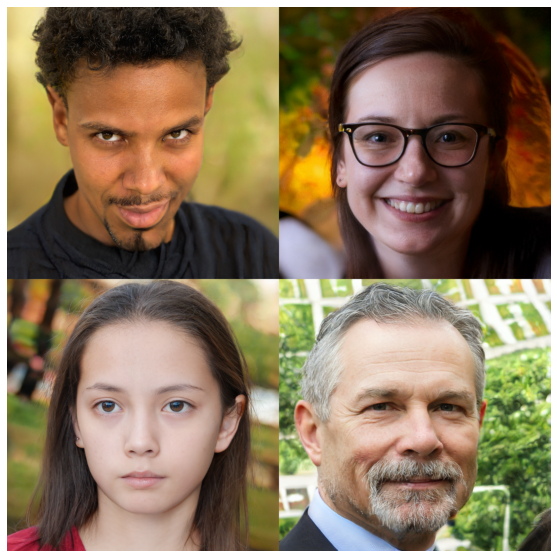

In [ ]:
print('Loading networks from "%s"...' % ckpt)
generator = Generator(z_dim=512, w_dim=512, c_dim=0, img_resolution=img_res, img_channels=3,
                      mapping_kwargs={'num_layers': num_layers},
                      synthesis_kwargs={'channel_base': channel_base,
                                        'channel_max': 512,
                                        'num_fp16_res': 4,
                                        'conv_clamp': 256})
param_dict = load_checkpoint(ckpt)
load_param_into_net(generator, param_dict)

os.makedirs(out_dir, exist_ok=True)

# Labels.
label = ms.numpy.zeros([1, generator.c_dim])

# Generate images.
imgs = []
for seed_idx, seed in enumerate(seeds):
    print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
    z = Tensor(np.random.RandomState(seed).randn(1, generator.z_dim))
    ws = generator.mapping.construct(z, label, truncation_psi=truncation_psi)
    img = generator.synthesis.construct(ws, noise_mode=noise_mode)
    if grid_size is not None:
        imgs.append(img)
    else:
        img = ops.clip_by_value(img.transpose(0, 2, 3, 1) * 127.5 + 128, 0, 255).astype(ms.uint8)
        PIL.Image.fromarray(img[0].asnumpy(), 'RGB').save(f'{out_dir}/seed{seed:04d}.png')
if grid_size is not None:
    imgs = ops.Concat()(imgs).asnumpy()
    save_image_grid(imgs, os.path.join(out_dir, f'image grid {seeds}.png'),
                    d_range=[-1, 1], size=grid_size)
    print('Saving %dx%d image grid ...' % (grid_size[0], grid_size[1]))

image = PIL.Image.open(f'{out_dir}/image grid {seeds}.png')
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

TensorFlow 框架下实现的 FFHQ 推理例图如下：<br>
<img src='./images/ffhq_tensorflow.png' align=left width=55% height=55%/>

对比可以看出，除了头发、胡子等由随机噪声控制的细节不一样之外，MindSpore 的推理效果是一致且令人满意的。

最后，我们来看看 Lsun Car 的 MindSpore 推理效果。<br><br>
定义 Lsun Car 的推理输入以覆盖前面的 FFHQ 推理输入。

In [ ]:
ckpt = './ckpt/lsun_car_wide/G_ema.ckpt' # Network checkpoint
seeds = num_range('6000-6005') # Random seeds to generate images
truncation_psi = 0.5 # GAN truncation trick
img_res = 512 # Image resolution, ffhq=1024, lsun_wide=512
out_dir = './generated_images/lsun_car_wide' # Output directory
grid_size = num_range('3,2') # Curate images in 3(column) x 2(row) grid

启动 Lsun Car 的模型推理。

Loading networks from "./ckpt/lsun_car_wide/G_ema.ckpt"...
Generating image for seed 6000 (0/6) ...
Generating image for seed 6001 (1/6) ...
Generating image for seed 6002 (2/6) ...
Generating image for seed 6003 (3/6) ...
Generating image for seed 6004 (4/6) ...
Generating image for seed 6005 (5/6) ...
Saving 3x2 image grid ...


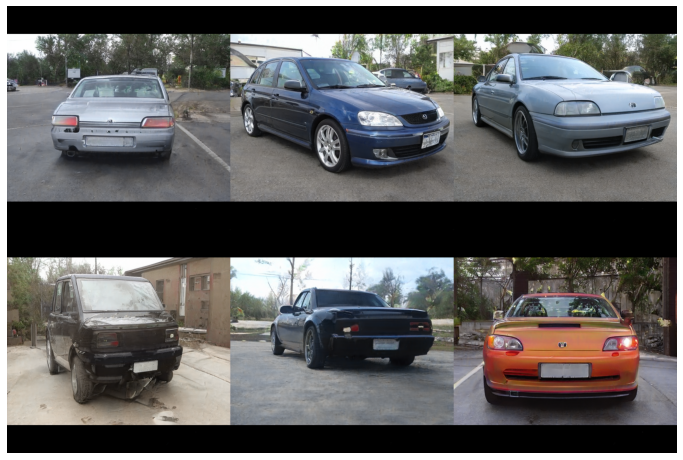

In [ ]:
print('Loading networks from "%s"...' % ckpt)
generator = Generator(z_dim=512, w_dim=512, c_dim=0, img_resolution=img_res, img_channels=3,
                      mapping_kwargs={'num_layers': num_layers},
                      synthesis_kwargs={'channel_base': channel_base,
                                        'channel_max': 512,
                                        'num_fp16_res': 4,
                                        'conv_clamp': 256})
param_dict = load_checkpoint(ckpt)
load_param_into_net(generator, param_dict)

os.makedirs(out_dir, exist_ok=True)

# Labels.
label = ms.numpy.zeros([1, generator.c_dim])

# Generate images.
imgs = []
for seed_idx, seed in enumerate(seeds):
    print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
    z = Tensor(np.random.RandomState(seed).randn(1, generator.z_dim))
    ws = generator.mapping.construct(z, label, truncation_psi=truncation_psi)
    img = generator.synthesis.construct(ws, noise_mode=noise_mode)
    if grid_size is not None:
        imgs.append(img)
    else:
        img = ops.clip_by_value(img.transpose(0, 2, 3, 1) * 127.5 + 128, 0, 255).astype(ms.uint8)
        PIL.Image.fromarray(img[0].asnumpy(), 'RGB').save(f'{out_dir}/seed{seed:04d}.png')
if grid_size is not None:
    imgs = ops.Concat()(imgs).asnumpy()
    save_image_grid(imgs, os.path.join(out_dir, f'image grid {seeds}.png'),
                    d_range=[-1, 1], size=grid_size)
    print('Saving %dx%d image grid ...' % (grid_size[0], grid_size[1]))

image = PIL.Image.open(f'{out_dir}/image grid {seeds}.png')
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

TensorFlow 框架下实现的 Lsun Car 推理例图如下：<br>
<img src='./images/lsun_car_tensorflow.png' align=left width=70% height=70%/>

对比发现，MindSpore 框架实现的推理图 和 通过Tensorflow 框架实现的推理图，效果基本一致，欢迎尝试 MindSpore 框架。

## 总结

本案例介绍了 StyleGAN 相较于传统 GAN 的优势与创新，并阐述了的 StyleGAN2 的重新设计 StyleGAN 生成器架构的动机与具体修改，详细介绍了 StyleGAN2 的实现细节，如训练流程，最后在模型推理中复现了通过 Tensorflow 实现的人脸生成与车辆生成。如需查看其他代码，请参考MindSpore Vision套件。

## 参考文献

[1] Karras T, Laine S, Aila T. [A style-based generator architecture for generative adversarial networks](https://openaccess.thecvf.com/content_CVPR_2020/papers/Karras_Analyzing_and_Improving_the_Image_Quality_of_StyleGAN_CVPR_2020_paper.pdf)\[C\]. Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019: 4401-4410.

[2] Karras T, Laine S, Aittala M, et al. [Analyzing and improving the image quality of stylegan](https://openaccess.thecvf.com/content_CVPR_2019/papers/Karras_A_Style-Based_Generator_Architecture_for_Generative_Adversarial_Networks_CVPR_2019_paper.pdf)\[C\]. Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020: 8110-8119.